<a href="https://colab.research.google.com/github/art-glazunov/MegaFon_RecSys_Workshop/blob/main/Part_4_1_Hybrid_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MegaFon RecSys workshop
by Artyom Glazunov

## Part 4.1. Hybrid recommender with LightFM library

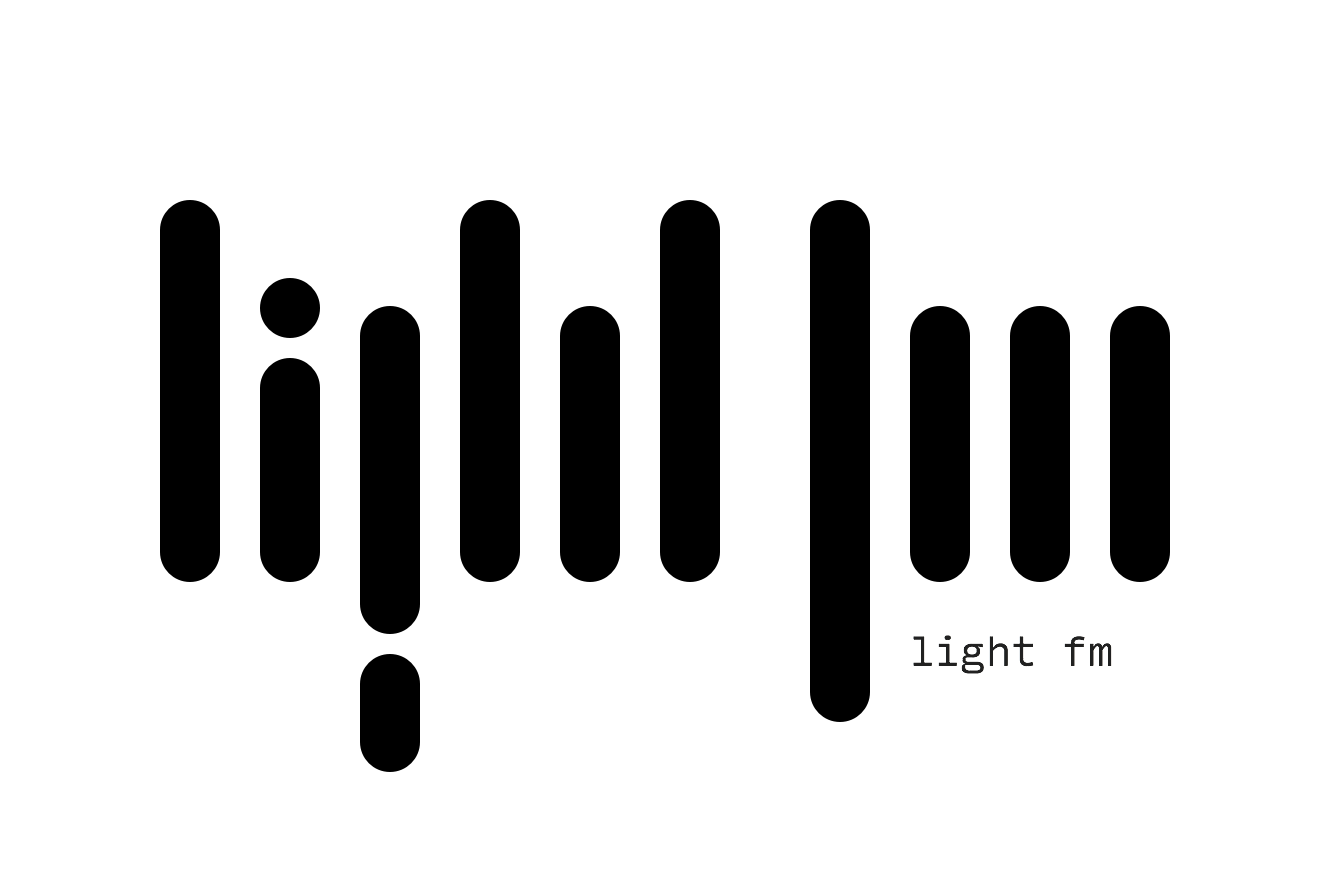

## The plan

- ### Data loading
- ### Useful classes and methods
- ### Solution without features
- ### Solution only on features
- ### Hybrid solution
- ### Hyperparameters search
- ### Final model evaluation
- ### Model saving 

In [ ]:
pip install -q lightfm==1.16

In [ ]:
pip install -q optuna

In [ ]:
import numpy as np
import pandas as pd
import scipy

import sklearn
from sklearn.base import TransformerMixin, BaseEstimator
import lightfm
from lightfm import data

import optuna
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

import warnings
import pickle

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/datafest_22/data

/content/drive/MyDrive/Colab_Notebooks/datafest_22/data


### Data loading

In [ ]:
data_train_pos = pd.read_csv("train_pos.csv")
data_train_all = pd.read_csv("train.csv")
data_val = pd.read_csv("validation.csv")
data_test = pd.read_csv("test.csv")
cold_users_data = pd.read_csv("cold_users_data.csv")
cold_items_data = pd.read_csv("cold_items_data.csv")

In [ ]:
data_train_pos.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=,my library,Local playlist more,local-library,1,248790.0,465,吳汶芳 (Fang Wu),吳汶芳,吳汶芳,3.0,孤獨的總和 (Accumulated Loneliness),TWA211328806,13,31,female,9,2011-04-19,2017-06-20
1,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=,my library,Local playlist more,local-library,1,178887.0,921,Noel Coward,NaN,NaN,52.0,Poor Little Rich Girl,USV291338277,5,33,female,9,2008-08-05,2017-10-06
2,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=,discover,Online playlist more,online-playlist,1,275136.0,465,田馥甄 (Hebe),楊子樸,施人誠,3.0,寂寞寂寞就好,TWD951043107,1,0,NaN,7,2011-02-25,2017-09-12
3,73q3/E5FIUwCSo9uPyhKcc1FNO9DqnaZqX7uDK5Rr7E=,XywiBSwrlFPkeg1pNJcH99AxP8loYVD8Twr+WrjjqxM=,discover,Online playlist more,online-playlist,1,199392.0,139|125|109,Al Green,Al Green,NaN,52.0,Let's Stay Together,US2HK0913701,1,0,NaN,7,2016-01-05,2017-10-05
4,M6fFPRO/pOaaWoergvHHsFzEUbW4YU6DKxqBDyYSbYU=,yiaUAbtf5E8J/aLzeDe3V/zT/sXzbZiIE3m/JvEB1jI=,search,Search,song,1,235416.0,444,Girls' Generation (少女時代),Cho Yun Kyoung| Kim Hee Jung| Harvey Mason Jr....,NaN,31.0,Mr.Mr.,KRA301300351,1,0,NaN,4,2016-12-13,2016-12-16


In [ ]:
data_train_all.shape, data_train_pos.shape, data_val.shape, data_test.shape, cold_users_data.shape, cold_items_data.shape

((5046332, 20),
 (2539875, 20),
 (630792, 20),
 (630792, 20),
 (715482, 20),
 (392174, 20))

### Useful classes and methods

First of all, I recommend you to look at some links on this topic:
- https://making.lyst.com/lightfm/docs/home.html
- http://building-babylon.net/2016/01/26/metadata-embeddings-for-user-and-item-cold-start-recommendations/
- https://arxiv.org/pdf/1507.08439.pdf

So, the typical graph for the final score calculation:

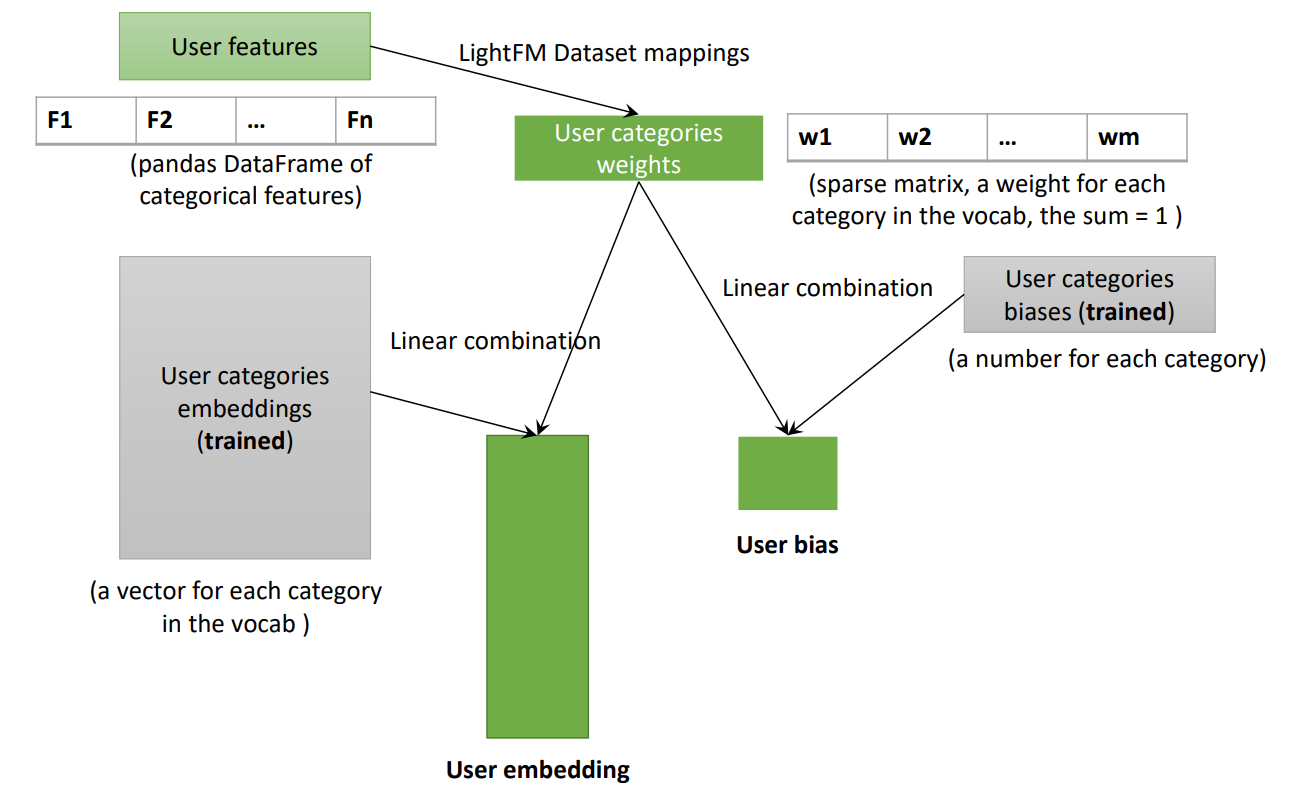

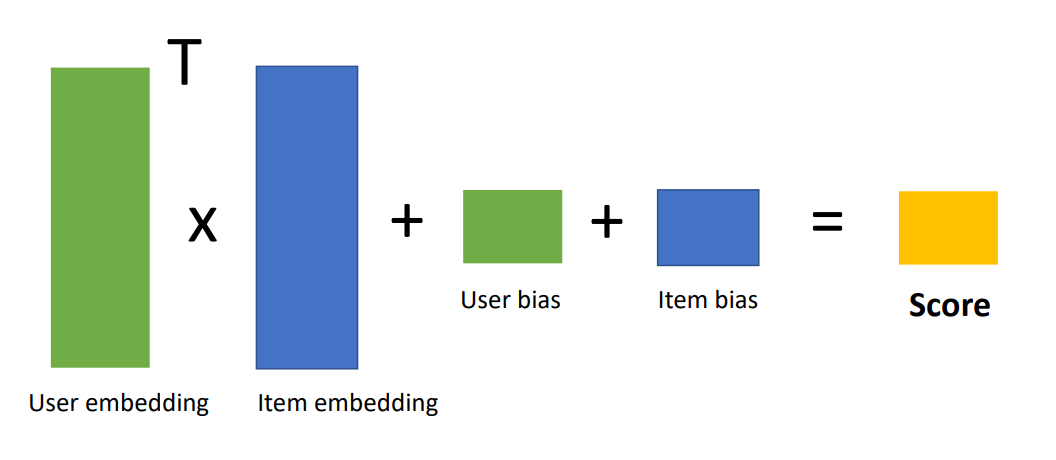

Although this graph describes the inference time, it is very similar to the training graph

In [ ]:
class ColumnCategorizer(TransformerMixin, BaseEstimator):
    """Creates new categorical features using continuous columns
    
    Requires 
    - quantiles list
    - columns to transform
    - new columns names
    """
    

    def __init__(self, qs, new_columns, old_columns):
        self.qs = qs #quantile list
        self.new_columns = new_columns #columns to create
        self.old_columns = old_columns #initial continuous columns
        self.transformers = {} #transformers storage
        

    def fit(self, X, y=None):
        """Fit transformers on a part of the columns
        X - train data
        """
        
        for column in self.old_columns:
            bins = np.unique([X[column].quantile(q=q) for q in self.qs])
            labels = [f"{column}_bin_{l_edge}_{r_edge}" for (l_edge, r_edge) in zip(bins[:-1], bins[1:])]
            self.transformers[column] = sklearn.preprocessing.FunctionTransformer(
                                             pd.cut, kw_args={'bins': bins, 
                                                              'include_lowest': True,
                                                              'labels': labels, 
                                                              'retbins': False}
                                                              ) 
            self.transformers[column].fit(X[column])
        return self
    

    def transform(self, X):
        """Transform data and return Pandas DataFrame
        X - data to transform
        """
        
        data_new = X.copy()
        for column_old, column_new in zip(self.old_columns, self.new_columns):
            data_new[column_new] = self.transformers[column_old].transform(data_new[column_old]).values
        return data_new


def names_to_cats(data_to_transform, cols):
    """Transform numeric categories using names of features
    
    data_to_transform - data to transform
    cols - columns to change
    """


    data_new = data_to_transform.copy()
    for col in cols:
        data_new[col] = data_new[col].apply(lambda x: f"{col}_{x}").values
    return data_new

In [ ]:
def get_mappings(dataset):
    """Prepare the mappings

    dataset - lightfm dataset object
    """
    result_dict = {}
    result_dict["user_id_mapping"] = dataset.mapping()[0]
    result_dict["item_id_mapping"] = dataset.mapping()[2]
    result_dict["user_fename_intid_mapping"] = dataset._user_feature_mapping
    result_dict["item_fename_intid_mapping"] = dataset._item_feature_mapping
    return result_dict


def get_cold_weights(data_val, fename_intid_mapping):
    """Get weights for COLD users/items

    data_val - our data with features
    fename_intid_mapping - mapping with ids and category names
    """

    row_ids = []
    col_ids = []
    for ind_r, features in enumerate(data_val.values):
        for cat_name in features:
            if cat_name in fename_intid_mapping:
                row_ids.append(ind_r)
                col_ids.append(fename_intid_mapping[cat_name])
    values = [1] * len(col_ids)

    result = sklearn.preprocessing.\
                      normalize(scipy.sparse.csr.\
                                csr_matrix((values, (row_ids, col_ids)),
                                            shape = (data_val.shape[0],
                                                    len(fename_intid_mapping))),
                                norm="l1", copy=False)
    return result


def get_id_weights_mapping(data_val, selected_cols, id_col, 
                           id_mapping, fename_intid_mapping, 
                           train_weights):
    """Get mapping with ids as keys
    and light fm sparse weights as values

    Brings hot and cold data and computes the weights matrix
    data_val - our data
    selected cols - column names WITH id column 
    id_col - user/item id column
    id_mapping - light fm external-internal id mapping
    fename_intid_mapping - mapping with ids and category names
    train_weights - weights from the train time (created via dataset object)
    """

    ids_set = data_val[id_col].unique()

    id_weights_mapping = {}
    cold_ids = []
    for ind in ids_set:
        if ind in id_mapping:
            id_weights_mapping[ind] = train_weights[id_mapping[ind]]
        else:
            cold_ids.append(ind)

    if len(cold_ids) > 0:
        data_select = data_val[selected_cols]
        data_cold = data_select[data_select[id_col].isin(cold_ids)].drop_duplicates()
        cold_weights = get_cold_weights(data_cold, fename_intid_mapping) 
        for ind, cold_entity in enumerate(data_cold[id_col]):
            id_weights_mapping[cold_entity] = cold_weights[ind]

    return id_weights_mapping


def get_lightfm_weights_tables_v2(data_val, user_id_col, item_id_col, 
                                  user_id_weights_mapping, 
                                  item_id_weights_mapping):
    """Prepare normalized OHE sparse matrices
    Considers both HOT and COLD users/items

    data_val - our data with features
    user_id_col - users id column
    item_id_col - item id column
    user_fename_intid_mapping, item_fename_intid_mapping - mappings
    """

    result_user = []
    result_item = []
    for user_ind, item_ind in zip(data_val[user_id_col], data_val[item_id_col]):
        result_user.append(user_id_weights_mapping[user_ind])
        result_item.append(item_id_weights_mapping[item_ind])

    return scipy.sparse.vstack(result_user), scipy.sparse.vstack(result_item)


def get_result_df(data_val, result_cols, scores):
    """Get resulting dataframe

    data_val - initial data with features
    result_cols - columns without scores (ids, other useful info)
    scores - predicted scores
    """
    
    real_pred_df = data_val[result_cols].copy()
    real_pred_df['score'] = scores
    return real_pred_df


def users_roc_auc_scores(real_pred_data, id_col="msno", 
                         target_col="target", score_col="score"):
    """Compute ROC AUC scores
    for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    roc_auc_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        roc_auc_scores.append(roc_auc_score(data_us[target_col], data_us[score_col]))
    return roc_auc_scores


def users_rr_scores(real_pred_data, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute RR scores for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    rr_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)\
                                .reset_index(drop=True)
        rr_score = 1 / ((data_us_sorted.target == 1).argmax() + 1)
        rr_scores.append(rr_score)
    return rr_scores


def precision_at_k(real_pred_data, k=5, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute precision@k scores for users

    real_pred_data - data with target and score
    k - size of the top 
    id_col- user_id column
    target_col, score_col - columns with target values and model's scores
    """

    precision_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)
        precision_score = data_us_sorted.iloc[:k].target.sum() / k
        precision_scores.append(precision_score)
    return precision_scores

In [ ]:
def lfm_train_preprocessing(data_train, 
                            categorizer,
                            cat_cols_to_change,
                            user_fe_cols,
                            item_fe_cols,
                            user_id_column,
                            item_id_column,
                            user_identity_features=True,
                            item_identity_features=True):
    """Get all the object needed for the lfm model training

    data_train - train_data
    categorizer - numeric columns categorizer object
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    user_identity_features - consider user id as a feature?
    item_identity_features - consider item id as a feature?
    """

    data_prep = categorizer.transform(names_to_cats(data_train, cat_cols_to_change))

    user_fe_data = data_prep[user_fe_cols].values
    item_fe_data = data_prep[item_fe_cols].values
    user_id = data_prep[user_id_column].values.ravel()
    item_id = data_prep[item_id_column].values.ravel()


    dataset = data.Dataset(user_identity_features=user_identity_features,
                           item_identity_features=item_identity_features)
    dataset.fit(users=user_id, items=item_id,
                user_features=user_fe_data.ravel(),
                item_features=item_fe_data.ravel())
    user_features = dataset.build_user_features(((x[0], x[1]) for x \
                                                    in zip(user_id, user_fe_data)))
    item_features = dataset.build_item_features(((x[0], x[1]) for x \
                                                    in zip(item_id, item_fe_data)))
    interactions, _ = dataset.build_interactions(((x[0], x[1]) for x \
                                                    in zip(user_id, item_id)))
    result = {"dataset" : dataset,
              "user_features": user_features,
              "item_features": item_features,
              "interactions": interactions}
    return result


def test_data_preprocessing(data_test, id="msno", k=10, 
                            min_prop=0.05, max_prop=0.95):
    """Pick only users 
    with both positive and negative responces

    data_test - data to transform
    id - user id column name
    k - minimum number of songs that a user interacted with
    min/max_prop - minimum/maximum limits for the proportion of 
    positive interactions in users histories
    """

    data_new = data_test.copy()
    val_users = []
    for user_id, data_us in data_new.groupby([id]):
        pos_cnt = data_us.target.sum()
        cnt = data_us.shape[0]
        pos_prop = pos_cnt / cnt
        if cnt >= k and pos_prop > min_prop and pos_prop < max_prop:
            val_users.append(user_id)    

    data_prep = data_new[data_new[id].isin(val_users)].reset_index(drop=True)
    return data_prep


def lfm_test_preprocessing(data_val, lfm_dataset,
                           categorizer,
                           k, cat_cols_to_change,
                           user_fe_cols,
                           item_fe_cols,
                           user_id_column,
                           item_id_column,
                           train_user_weights,
                           train_item_weights,
                           min_prop=0.05, max_prop=0.95):
    """Get all the objects needed for model testing

    data_val - test data
    lfm_dataset - lightfm dataset object
    categorizer - numeric columns categorizer object
    k - test_data_preprocessing() method parameter (minumum user's history size)
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    train_user_weights - matrix from dataset.build_user_features() 
        method before the training
    train_item_weights - matrix from dataset.build_item_features() 
        method before the training
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """

    data_select = test_data_preprocessing(data_val, id=user_id_column, k=k,
                                          min_prop=min_prop, max_prop=max_prop)
    data_prep = categorizer.transform(names_to_cats(data_select, 
                                                    cat_cols_to_change))
    user_cols = [user_id_column] + user_fe_cols
    item_cols = [item_id_column] + item_fe_cols

    mappings = get_mappings(lfm_dataset)
    user_id_mapping = mappings["user_id_mapping"]
    item_id_mapping = mappings["item_id_mapping"]
    user_fename_intid_mapping = mappings["user_fename_intid_mapping"]
    item_fename_intid_mapping = mappings["item_fename_intid_mapping"]

    user_id_weights_mapping = get_id_weights_mapping(data_prep, 
                                                     selected_cols=user_cols,
                                                     id_col=user_id_column, 
                                                     id_mapping=user_id_mapping, 
                                                     fename_intid_mapping=user_fename_intid_mapping, 
                                                     train_weights=train_user_weights)
    item_id_weights_mapping = get_id_weights_mapping(data_prep, 
                                                     selected_cols=item_cols,
                                                     id_col=item_id_column, 
                                                     id_mapping=item_id_mapping, 
                                                     fename_intid_mapping=item_fename_intid_mapping, 
                                                     train_weights=train_item_weights)
    
    u_weights, i_weights = get_lightfm_weights_tables_v2(data_prep, 
                                                         user_id_column, item_id_column,
                                                         user_id_weights_mapping, 
                                                         item_id_weights_mapping)
    ids = np.array(list(range(u_weights.shape[0])))

    result_dict = {"data_prep": data_prep,
                   "ids": ids,
                   "u_weights": u_weights,
                   "i_weights": i_weights}
    return result_dict


def lfm_model_evaluation(model, data_val, 
                         categorizer,
                         result_cols, 
                         lfm_dataset,
                         train_user_weights,
                         train_item_weights,
                         n, cat_cols_to_change,
                         user_fe_cols,
                         item_fe_cols,
                         user_id_column,
                         item_id_column,
                         k=5,
                         num_threads=4,
                         min_prop=0.05, max_prop=0.95):
    """Light FM model evaluation method

    model - lfm model
    data_val - validation dataframe
    categorizer - numeric columns categorizer object
    result_cols - columns in the resulting dataframe (without score column)
    lfm_dataset - lightfm dataset object
    train_user_weights - matrix from dataset.build_user_features() 
        method before the training
    train_item_weights - matrix from dataset.build_item_features() 
        method before the training
    n - test_data_preprocessing() method parameter
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    k - precision_at_k() method parameter
    num_threads - num threads for parallelization of calculations
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """


    val_result_dict = lfm_test_preprocessing(data_val=data_val, 
                                             lfm_dataset=lfm_dataset,
                                             categorizer=categorizer,
                                             k=n, cat_cols_to_change=cat_cols_to_change,
                                             user_fe_cols=user_fe_cols,
                                             item_fe_cols=item_fe_cols,
                                             user_id_column=user_id_column,
                                             item_id_column=item_id_column,
                                             train_user_weights=train_user_weights,
                                             train_item_weights=train_item_weights,
                                             min_prop=min_prop, max_prop=max_prop)
    data_val_prep = val_result_dict["data_prep"]
    val_ids = val_result_dict["ids"]
    val_u_weights = val_result_dict["u_weights"]
    val_i_weights = val_result_dict["i_weights"]

    user_items_scores_val = model.predict(user_ids=val_ids,
                                          user_features=val_u_weights,
                                          item_ids=val_ids,
                                          item_features=val_i_weights,
                                          num_threads=num_threads)

    val_real_pred = get_result_df(data_val_prep, result_cols, user_items_scores_val)
    roc_auc_scores = users_roc_auc_scores(val_real_pred)
    rr_scores = users_rr_scores(val_real_pred)
    p_at_k_scores = precision_at_k(val_real_pred, k=k)
    print(f"Users mean AUC ROC on test: {np.mean(roc_auc_scores)}")
    print(f"Users mean reciprocal rank on test: {np.mean(rr_scores)}")
    print(f"Users mean precision@{k} on test: {np.mean(p_at_k_scores)}")
    plt.figure()
    plt.hist(roc_auc_scores)
    plt.title("USERS AUC ROC SCORES")
    plt.grid()
    plt.figure()
    plt.hist(rr_scores)
    plt.title(f"USERS RECIPROCAL RANK SCORES")
    plt.grid()
    plt.figure()
    plt.hist(p_at_k_scores)
    plt.title(f"USERS PRECISION@{k} SCORES")
    plt.grid()
    return val_real_pred


def get_mean_roc_auc(model, data_val, result_cols, 
                    lfm_dataset,
                    categorizer,
                    train_user_weights,
                    train_item_weights,
                    n, cat_cols_to_change,
                    user_fe_cols,
                    item_fe_cols,
                    user_id_column,
                    item_id_column,
                    num_threads=4,
                    min_prop=0.05, max_prop=0.95):
    """Get mean AUC ROC for users for optimization

    model - lfm model
    data_val - validation dataframe
    result_cols - columns in the resulting dataframe (without score column)
    lfm_dataset - lightfm dataset object
    categorizer - numeric columns categorizer object
    train_user_weights - matrix from dataset.build_user_features() 
        method before the training
    train_item_weights - matrix from dataset.build_item_features() 
        method before the training
    n - test_data_preprocessing() method parameter
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    num_threads - num threads for parallelization of calculations
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """
    
    val_result_dict = lfm_test_preprocessing(data_val=data_val, 
                                             lfm_dataset=lfm_dataset,
                                             categorizer=categorizer,
                                             k=n, cat_cols_to_change=cat_cols_to_change,
                                             user_fe_cols=user_fe_cols,
                                             item_fe_cols=item_fe_cols,
                                             user_id_column=user_id_column,
                                             item_id_column=item_id_column,
                                             train_user_weights=train_user_weights,
                                             train_item_weights=train_item_weights,
                                             min_prop=min_prop, max_prop=max_prop)
    data_val_prep = val_result_dict["data_prep"]
    val_ids = val_result_dict["ids"]
    val_u_weights = val_result_dict["u_weights"]
    val_i_weights = val_result_dict["i_weights"]

    user_items_scores_val = model.predict(user_ids=val_ids,
                                          user_features=val_u_weights,
                                          item_ids=val_ids,
                                          item_features=val_i_weights,
                                          num_threads=num_threads)

    val_real_pred = get_result_df(data_val_prep, result_cols, user_items_scores_val)
    roc_auc_scores = users_roc_auc_scores(val_real_pred)
    return np.mean(roc_auc_scores)

In [ ]:
!nproc --all

4


In [ ]:
#######
NUM_THREADS = 4 #Number of colab cores
#######

### Without additional features, only responces in train

In [ ]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = []
item_fe_cols = []
user_id_column = "msno"
item_id_column = "song_id"

#Other lists of features
cat_cols_to_change = [] #columns to add name to value
numeric_cols = [] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, "target"]

#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#Categorizer for numeric features (here - only patch for interfaces)
categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=[], old_columns=[],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
%%time
prep_dict = lfm_train_preprocessing(data_train_pos,
                                    categorizer=categorizer,
                                    cat_cols_to_change=cat_cols_to_change,
                                    user_fe_cols=user_fe_cols,
                                    item_fe_cols=item_fe_cols,
                                    user_id_column=user_id_column,
                                    item_id_column=item_id_column,
                                    user_identity_features=True,
                                    item_identity_features=True)
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 25.3 s, sys: 320 ms, total: 25.6 s
Wall time: 25.8 s


In [ ]:
%%time
#####
EPOCH_NUM = 10

model_params = {"loss": "warp",
                "random_state": 0,
                "no_components": 100}
#####

model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    model.fit_partial(interactions=interactions,
                      user_features=user_features,
                      item_features=item_features,
                      num_threads=NUM_THREADS)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
CPU times: user 4min 35s, sys: 145 ms, total: 4min 35s
Wall time: 1min 12s


### Let's evaluate our model on different test sets

----------
Validation data
----------
Users mean AUC ROC on test: 0.661327443752265
Users mean reciprocal rank on test: 0.9204995054401583
Users mean precision@5 on test: 0.8154302670623144


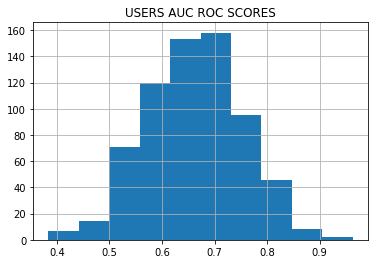

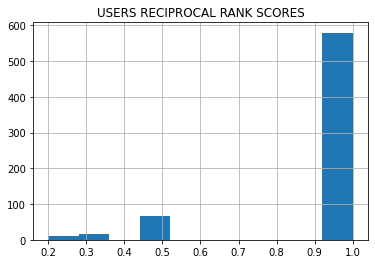

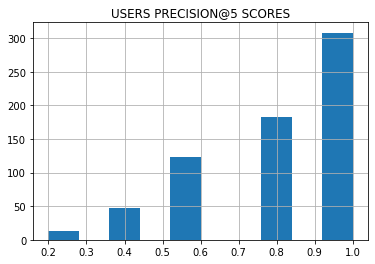

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Validation data")
print("----------")
val_real_pred = lfm_model_evaluation(model, data_val,
                                     result_cols=result_cols, 
                                     lfm_dataset=dataset,
                                     categorizer=categorizer,
                                     n=K, cat_cols_to_change=cat_cols_to_change,
                                     user_fe_cols=user_fe_cols,
                                     item_fe_cols=item_fe_cols,
                                     user_id_column=user_id_column,
                                     item_id_column=item_id_column,
                                     train_user_weights=user_features,
                                     train_item_weights=item_features,
                                     min_prop=MIN_PROP, max_prop=MAX_PROP)

Check out our scores

In [ ]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,-3.065443
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,-2.055474
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,-5.588553
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,-0.335178
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,1.136305


----------
Test data
----------
Users mean AUC ROC on test: 0.6660336099196881
Users mean reciprocal rank on test: 0.9267795414462081
Users mean precision@5 on test: 0.8296296296296296


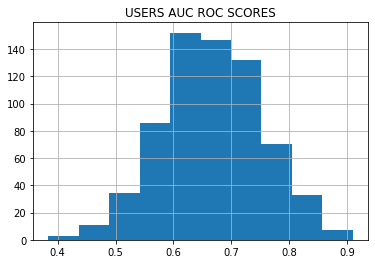

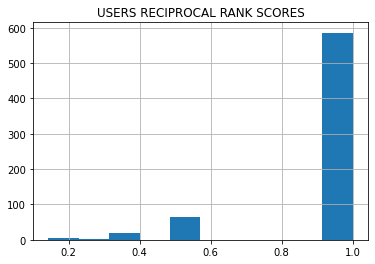

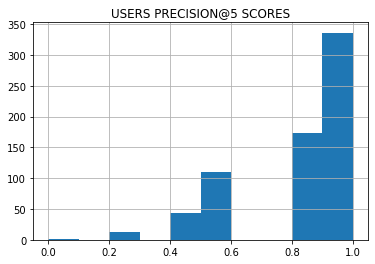

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Test data")
print("----------")
_ = lfm_model_evaluation(model, data_test,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features,
                        min_prop=MIN_PROP, max_prop=MAX_PROP)

----------
Cold users data
----------
Users mean AUC ROC on test: 0.5922749107831183
Users mean reciprocal rank on test: 0.8528699329217417
Users mean precision@5 on test: 0.7411622276029056


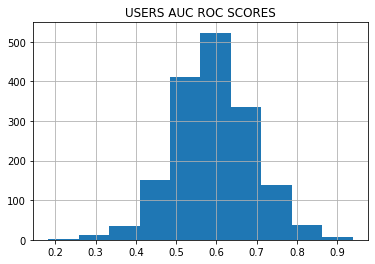

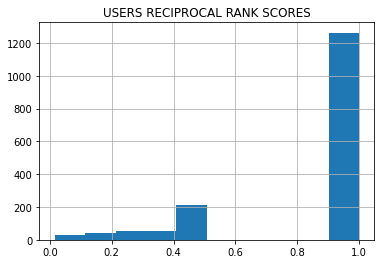

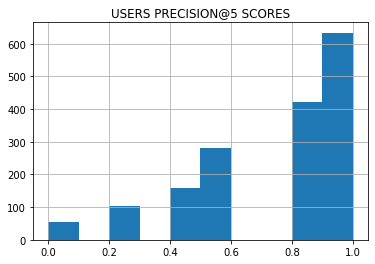

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold users data")
print("----------")
_ = lfm_model_evaluation(model, cold_users_data,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features)

----------
Cold items data
----------
Users mean AUC ROC on test: 0.5
Users mean reciprocal rank on test: 0.672866971838803
Users mean precision@5 on test: 0.48732394366197185


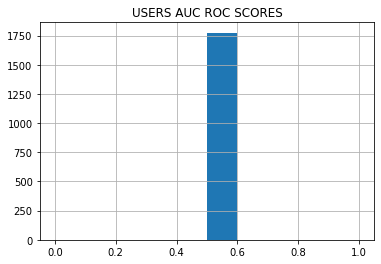

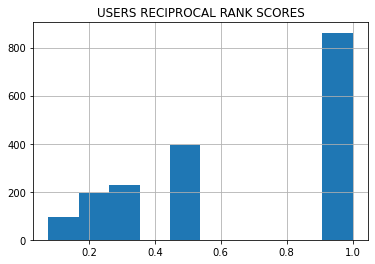

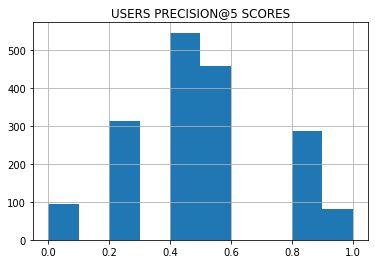

In [ ]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold items data")
print("----------")
_ = lfm_model_evaluation(model, cold_items_data,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features,
                        min_prop=MIN_PROP, max_prop=MAX_PROP)

### You can see that in the last case with cold items the model works as a random algorithm. Can we do better?

### Let's try to build a model only on features, without any responces data

In [ ]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = ["city", "gender", "bd", "registered_via"]
item_fe_cols = ["song_length", "genre_ids", "artist_name", "composer", "language", "source_type"]
user_id_column = "msno"
item_id_column = "song_id"

#Other lists of features
cat_cols_to_change = ["genre_ids", "language", "city", "registered_via"] #columns to add name to value
numeric_cols = ["bd", "song_length"] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, "target"]

#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#Numeric features categorizer
categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=['bd', 'song_length'],
                  old_columns=['bd', 'song_length'],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
%%time
prep_dict = lfm_train_preprocessing(data_train_pos,
                                    categorizer=categorizer,
                                    cat_cols_to_change=cat_cols_to_change,
                                    user_fe_cols=user_fe_cols,
                                    item_fe_cols=item_fe_cols,
                                    user_id_column=user_id_column,
                                    item_id_column=item_id_column,
                                    user_identity_features=False, #look at this parameter
                                    item_identity_features=False) #look at this parameter
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 1min 9s, sys: 1.19 s, total: 1min 10s
Wall time: 1min 10s


In [ ]:
%%time
#####
EPOCH_NUM = 10
model_params = {"loss": "warp",
                "random_state": 0,
                "no_components": 100}
#####

model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    model.fit_partial(interactions=interactions,
                      user_features=user_features,
                      item_features=item_features,
                      num_threads=NUM_THREADS)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
CPU times: user 19min, sys: 582 ms, total: 19min
Wall time: 4min 52s


----------
Validation data
----------
Users mean AUC ROC on test: 0.6092518155125741
Users mean reciprocal rank on test: 0.8623717034696263
Users mean precision@5 on test: 0.7181008902077152


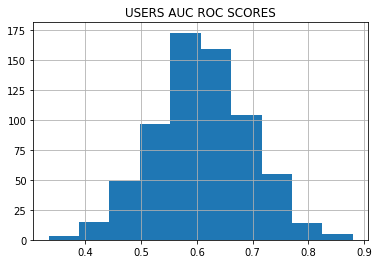

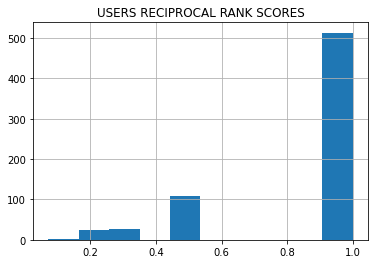

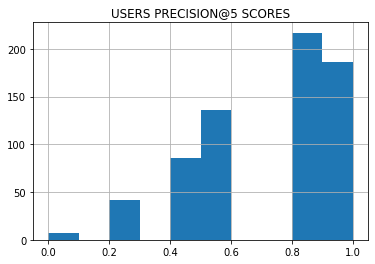

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Validation data")
print("----------")
val_real_pred = lfm_model_evaluation(model, data_val,
                                     result_cols=result_cols, 
                                     lfm_dataset=dataset,
                                     categorizer=categorizer,
                                     n=K, cat_cols_to_change=cat_cols_to_change,
                                     user_fe_cols=user_fe_cols,
                                     item_fe_cols=item_fe_cols,
                                     user_id_column=user_id_column,
                                     item_id_column=item_id_column,
                                     train_user_weights=user_features,
                                     train_item_weights=item_features,
                                     min_prop=MIN_PROP, max_prop=MAX_PROP)

----------
Cold items data
----------
Users mean AUC ROC on test: 0.5674813826269944
Users mean reciprocal rank on test: 0.7144284291608236
Users mean precision@5 on test: 0.5385915492957747


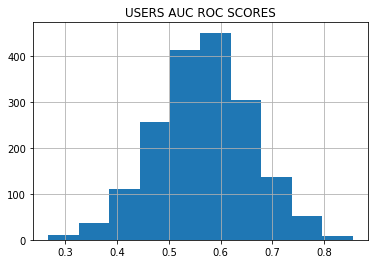

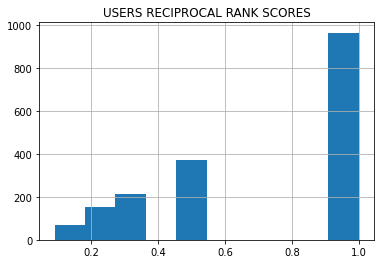

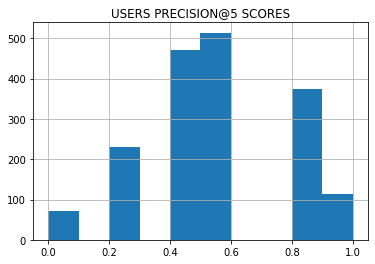

In [ ]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold items data")
print("----------")
_ = lfm_model_evaluation(model, cold_items_data,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features,
                        min_prop=MIN_PROP, max_prop=MAX_PROP)

### So, we have the result for the last case, but quality on the other sets is worse... Let's try to use only responces for users and only features for items.

In [ ]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = "msno"
item_id_column = "song_id"

#Other lists of features
cat_cols_to_change = ["genre_ids", "language"] #columns to add name to value
numeric_cols = [] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, "target"]

#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#Categorizer for numeric features (here, it's only a patch for our interfaces)
categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=[], old_columns=[],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
%%time
prep_dict = lfm_train_preprocessing(data_train_pos,
                                    categorizer=categorizer,
                                    cat_cols_to_change=cat_cols_to_change,
                                    user_fe_cols=user_fe_cols,
                                    item_fe_cols=item_fe_cols,
                                    user_id_column=user_id_column,
                                    item_id_column=item_id_column,
                                    user_identity_features=True,
                                    item_identity_features=False)
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 45.3 s, sys: 1.18 s, total: 46.5 s
Wall time: 46.3 s


In [ ]:
%%time
#####
EPOCH_NUM = 10
model_params = {"loss": "warp",
                "random_state": 0,
                "no_components": 100}
#####

model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    model.fit_partial(interactions=interactions,
                      user_features=user_features,
                      item_features=item_features,
                      num_threads=NUM_THREADS)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
CPU times: user 8min 42s, sys: 214 ms, total: 8min 43s
Wall time: 2min 15s


----------
Validation data
----------
Users mean AUC ROC on test: 0.6577489966643787
Users mean reciprocal rank on test: 0.885078423060619
Users mean precision@5 on test: 0.7620178041543025


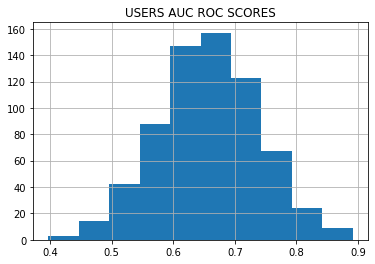

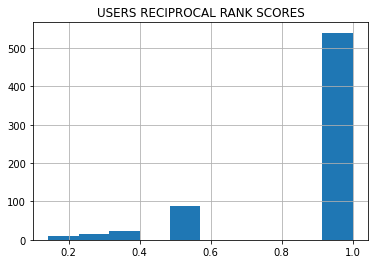

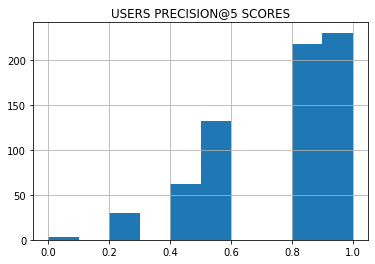

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Validation data")
print("----------")
val_real_pred = lfm_model_evaluation(model, data_val,
                                     result_cols=result_cols, 
                                     lfm_dataset=dataset,
                                     categorizer=categorizer,
                                     n=K, cat_cols_to_change=cat_cols_to_change,
                                     user_fe_cols=user_fe_cols,
                                     item_fe_cols=item_fe_cols,
                                     user_id_column=user_id_column,
                                     item_id_column=item_id_column,
                                     train_user_weights=user_features,
                                     train_item_weights=item_features,
                                     min_prop=MIN_PROP, max_prop=MAX_PROP)

----------
Test data
----------
Users mean AUC ROC on test: 0.6607598389185708
Users mean reciprocal rank on test: 0.8914126984126984
Users mean precision@5 on test: 0.7733333333333333


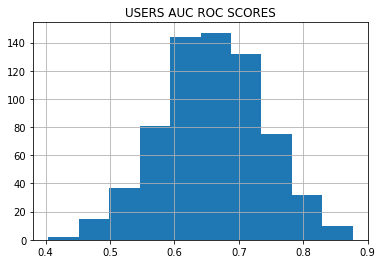

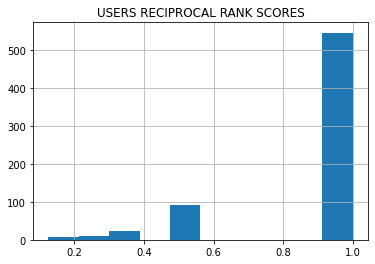

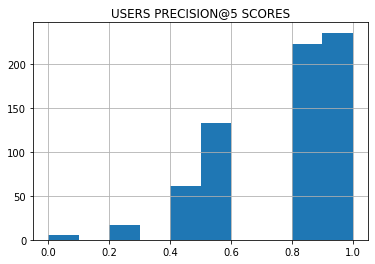

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Test data")
print("----------")
_ = lfm_model_evaluation(model, data_test,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features,
                        min_prop=MIN_PROP, max_prop=MAX_PROP)

----------
Cold users data
----------
Users mean AUC ROC on test: 0.5757764001305418
Users mean reciprocal rank on test: 0.790879590809948
Users mean precision@5 on test: 0.6322033898305085


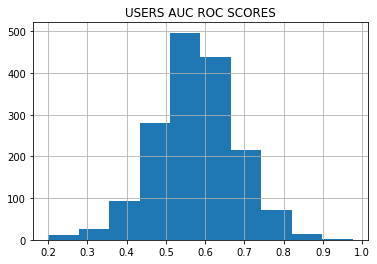

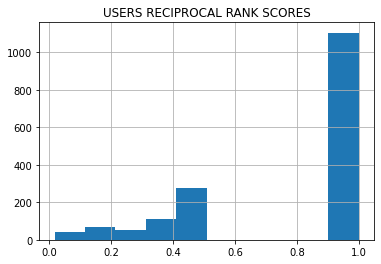

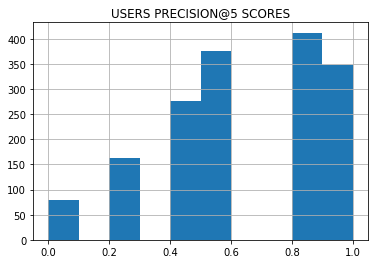

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold users data")
print("----------")
_ = lfm_model_evaluation(model, cold_users_data,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features)

----------
Cold items data
----------
Users mean AUC ROC on test: 0.6252327825097638
Users mean reciprocal rank on test: 0.8021931792776864
Users mean precision@5 on test: 0.6582535211267606


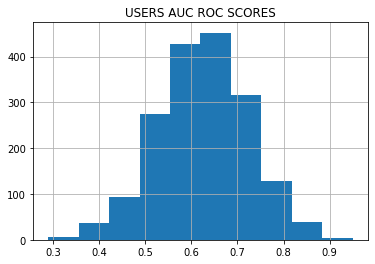

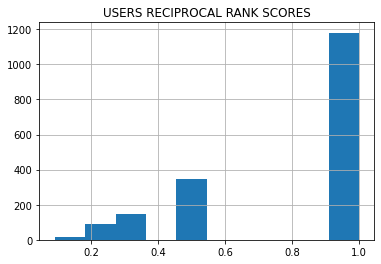

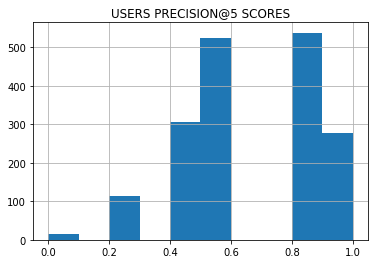

In [ ]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold items data")
print("----------")
_ = lfm_model_evaluation(model, cold_items_data,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features,
                        min_prop=MIN_PROP, max_prop=MAX_PROP)

### Better results!

### So, here we'll tune the hyperparameters via optuna and find the best algorithm (only a starter, you can try more combinations).

In [ ]:
warnings.filterwarnings('ignore')

######
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)

K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75

EPOCH_NUM = 2
NUM_THREADS = 4

user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = "msno"
item_id_column = "song_id"

cat_cols_to_change = ["genre_ids", "language", "city", "registered_via"] #columns to add a name to a value
numeric_cols = ["bd"] #this columns will be categorized

#Columns in the result dataframe with targets
result_cols = [user_id_column, item_id_column, "target"]

categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_all)

N_TRIALS = 20
######

def objective(trial):
    ##
    include_user_features = trial.suggest_categorical(
                                "include_user_features", ["Yes", "No"]
                                )
    user_fe_cols = []
    if include_user_features == "Yes":
        user_fe_cols = ["city", "gender", "bd", "registered_via"]
    ##
    prep_dict = lfm_train_preprocessing(data_train_pos,
                                        categorizer=categorizer,
                                        cat_cols_to_change=cat_cols_to_change,
                                        user_fe_cols=user_fe_cols,
                                        item_fe_cols=item_fe_cols,
                                        user_id_column=user_id_column,
                                        item_id_column=item_id_column,
                                        user_identity_features=True,
                                        item_identity_features=False)
    dataset = prep_dict["dataset"]
    interactions = prep_dict["interactions"]
    user_features = prep_dict["user_features"]
    item_features = prep_dict["item_features"]
    
    params = {
        "no_components": trial.suggest_int("no_components", 10, 200),
        "loss": trial.suggest_categorical("loss", ["warp", "bpr"])
    }
    params["random_state"] = 0    

    model = lightfm.LightFM(**params)
    for epoch in range(0, EPOCH_NUM):
        model.fit_partial(interactions=interactions,
                          user_features=user_features,
                          item_features=item_features,
                          num_threads=NUM_THREADS)
    
    mean_roc_auc_score = get_mean_roc_auc(model, data_val,
                                          result_cols=result_cols, 
                                          lfm_dataset=dataset,
                                          categorizer=categorizer,
                                          n=K, cat_cols_to_change=cat_cols_to_change,
                                          user_fe_cols=user_fe_cols,
                                          item_fe_cols=item_fe_cols,
                                          user_id_column=user_id_column,
                                          item_id_column=item_id_column,
                                          train_user_weights=user_features,
                                          train_item_weights=item_features,
                                          min_prop=MIN_PROP, max_prop=MAX_PROP)
    return mean_roc_auc_score

study = optuna.create_study(direction="maximize", study_name="my_lfm_optimization")
study.optimize(objective, n_trials=N_TRIALS)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-05-03 11:00:17,847] A new study created in memory with name: my_lfm_optimization
[I 2022-05-03 11:02:44,221] Trial 0 finished with value: 0.5516391453765961 and parameters: {'include_user_features': 'Yes', 'no_components': 183, 'loss': 'bpr'}. Best is trial 0 with value: 0.5516391453765961.
[I 2022-05-03 11:04:36,416] Trial 1 finished with value: 0.5779263461952789 and parameters: {'include_user_features': 'No', 'no_components': 153, 'loss': 'bpr'}. Best is trial 1 with value: 0.5779263461952789.
[I 2022-05-03 11:06:31,440] Trial 2 finished with value: 0.576359901678818 and parameters: {'include_user_features': 'No', 'no_components': 189, 'loss': 'bpr'}. Best is trial 1 with value: 0.5779263461952789.
[I 2022-05-03 11:07:46,351] Trial 3 finished with value: 0.57230565855309 and parameters: {'include_user_features': 'No', 'no_components': 31, 'loss': 'bpr'}. Best is trial 1 with value: 0.5779263461952789.
[I 2022-05-03 11:09:27,850] Trial 4 finished with value: 0.578149398855492

Number of finished trials: 20
Best trial:
  Value: 0.6454364965181858
  Params: 
    include_user_features: No
    no_components: 200
    loss: warp


In [ ]:
trial.params

{'include_user_features': 'No', 'loss': 'warp', 'no_components': 200}

In [ ]:
#####
EPOCH_NUM = 30
#####


user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]


prep_dict = lfm_train_preprocessing(data_train_pos,
                                    categorizer=categorizer,
                                    cat_cols_to_change=cat_cols_to_change,
                                    user_fe_cols=user_fe_cols,
                                    item_fe_cols=item_fe_cols,
                                    user_id_column=user_id_column,
                                    item_id_column=item_id_column,
                                    user_identity_features=True,
                                    item_identity_features=False)
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]


model_params = {}
model_params["loss"] = trial.params["loss"]
model_params["no_components"] = trial.params["no_components"]
model_params["random_state"] = 0  
model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    model.fit_partial(interactions=interactions,
                      user_features=user_features,
                      item_features=item_features,
                      num_threads=NUM_THREADS)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


----------
Validation data
----------
Users mean AUC ROC on test: 0.6768791216884931
Users mean reciprocal rank on test: 0.9011745796241345
Users mean precision@5 on test: 0.783679525222552


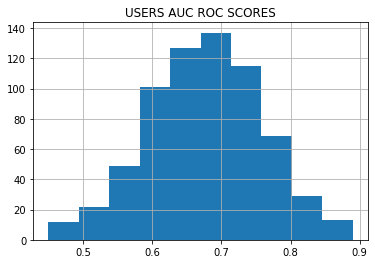

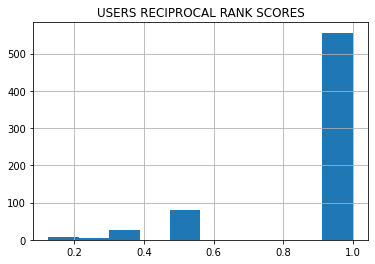

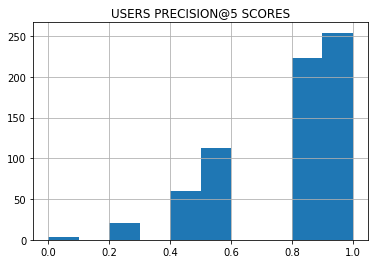

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Validation data")
print("----------")
val_real_pred = lfm_model_evaluation(model, data_val,
                                     result_cols=result_cols, 
                                     lfm_dataset=dataset,
                                     categorizer=categorizer,
                                     n=K, cat_cols_to_change=cat_cols_to_change,
                                     user_fe_cols=user_fe_cols,
                                     item_fe_cols=item_fe_cols,
                                     user_id_column=user_id_column,
                                     item_id_column=item_id_column,
                                     train_user_weights=user_features,
                                     train_item_weights=item_features,
                                     min_prop=MIN_PROP, max_prop=MAX_PROP)

In [ ]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,-4.203632
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,-5.776087
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,-6.903784
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,-0.929557
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,-2.824098


----------
Test data
----------
Users mean AUC ROC on test: 0.6784206255938234
Users mean reciprocal rank on test: 0.8994197530864197
Users mean precision@5 on test: 0.7943703703703703


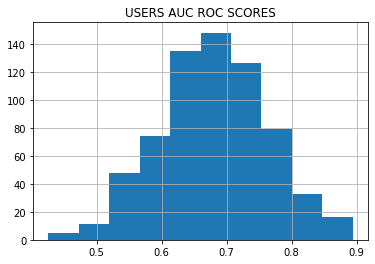

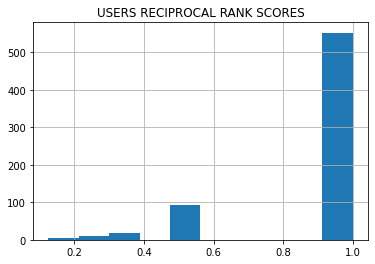

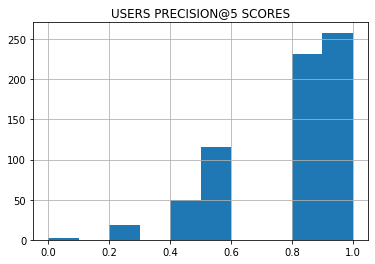

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Test data")
print("----------")
_ = lfm_model_evaluation(model, data_test,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features,
                        min_prop=MIN_PROP, max_prop=MAX_PROP)

----------
Cold users data
----------
Users mean AUC ROC on test: 0.5749643686355662
Users mean reciprocal rank on test: 0.7919451299429366
Users mean precision@5 on test: 0.6429782082324454


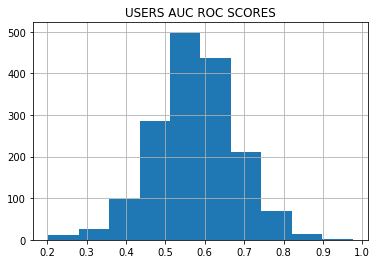

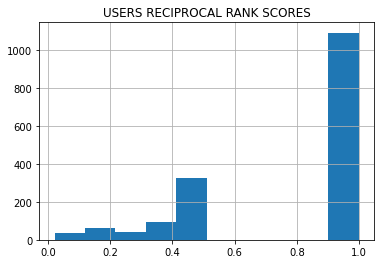

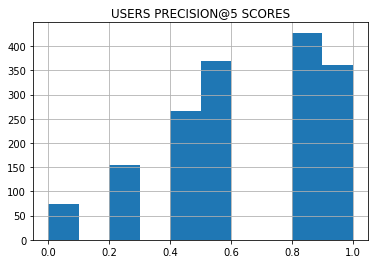

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold users data")
print("----------")
_ = lfm_model_evaluation(model, cold_users_data,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features)

----------
Cold items data
----------
Users mean AUC ROC on test: 0.633962793951044
Users mean reciprocal rank on test: 0.7994033087413369
Users mean precision@5 on test: 0.6750422535211267


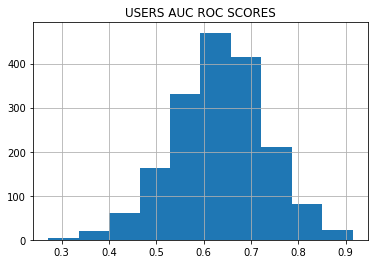

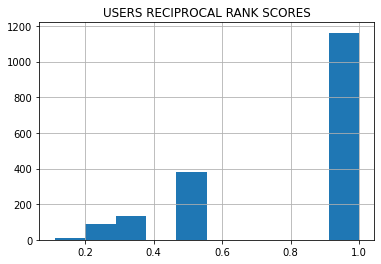

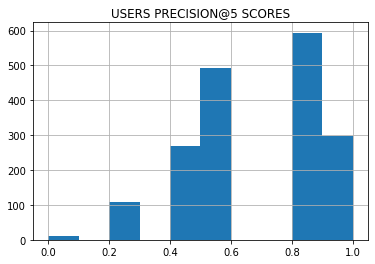

In [ ]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold items data")
print("----------")
_ = lfm_model_evaluation(model, cold_items_data,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features,
                        min_prop=MIN_PROP, max_prop=MAX_PROP)

----------
Train data
----------
Users mean AUC ROC on test: 0.739806438345371
Users mean reciprocal rank on test: 0.9131422881598813
Users mean precision@5 on test: 0.8320900774102745


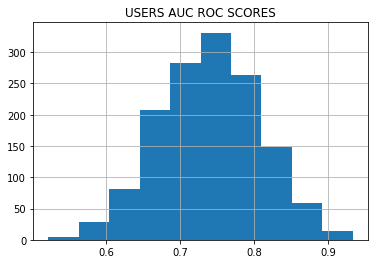

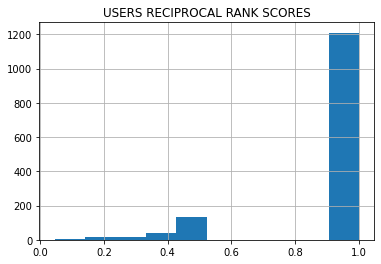

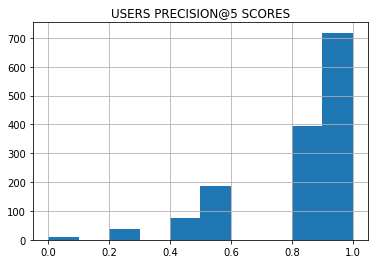

In [ ]:
#####
K = 600
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Train data")
print("----------")

_ = lfm_model_evaluation(model, data_train_all,
                        result_cols=result_cols, 
                        lfm_dataset=dataset,
                        categorizer=categorizer,
                        n=K, cat_cols_to_change=cat_cols_to_change,
                        user_fe_cols=user_fe_cols,
                        item_fe_cols=item_fe_cols,
                        user_id_column=user_id_column,
                        item_id_column=item_id_column,
                        train_user_weights=user_features,
                        train_item_weights=item_features,
                        min_prop=MIN_PROP, max_prop=MAX_PROP)

### Not bad results, aren't they?)

### Save the model

In [ ]:
!rm ../models/lfm_model.pkl

In [ ]:
with open("../models/lfm_model.pkl", "wb") as fout:
    pickle.dump(model, fout)
with open("../models/lfm_model.pkl", "rb") as fin:
    new_model = pickle.load(fin)

In [ ]:
assert (model.get_item_representations()[1] == new_model.get_item_representations()[1]).all()

### Stay tuned! :)